In [5]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

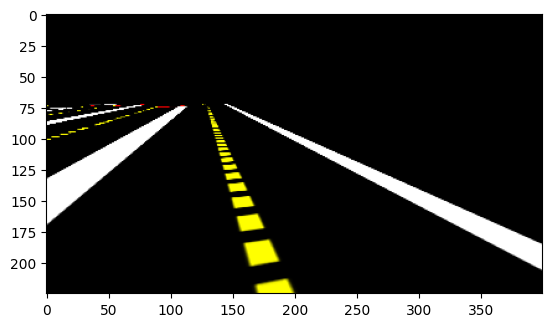

In [14]:
img = cv.imread('./sim_testing_images/straight.png')[:,:,::-1] #TODO: FIX THIS DISASTER FROM DANIEL, WHICH THEORETICALLY CONVERTS RBG2BGR
plt.imshow(img)


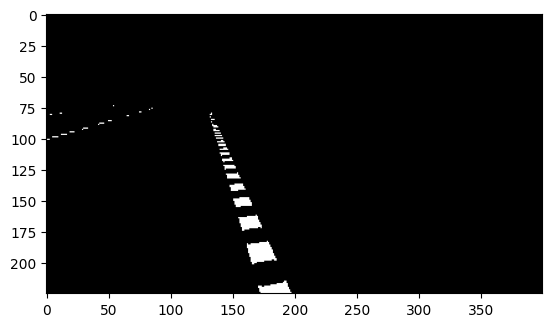

In [24]:
# hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
lower_yellow = np.array([254,254,0])
upper_yellow = np.array([255,255,0])

thresholdImg = cv.inRange(img, lower_yellow, upper_yellow)
plt.imshow(thresholdImg, cmap='gray')

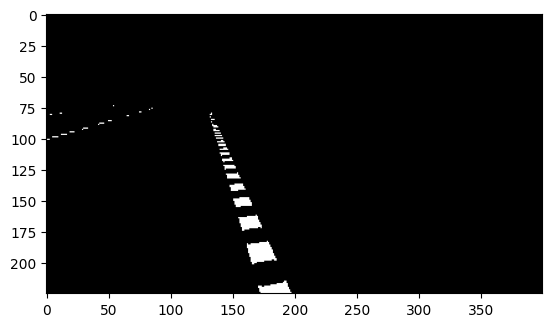